# Convolutional Neural Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

Recall that in previous notebooks to classify images we flattened them into long vectors as inputs to MLPs. This is unstatisfying since we are discarding important spatial information, i.e. observe that MLPs are invariant to a permutation of the neurons. In addition to this, a dense layer taking in a 256×256 RGB image producing a 256×256×3 image of the same dimensions would require around 39 billion parameters. This requires too much memory and results in excess capacity for a single layer.

It would be nice if we can include our prior knowledge that pixels are spatially related in some way into the structure of our networks. For tasks such as object detection and classification, we can abstract away two desirable properties: **translation invariance** and **locality**. For our purposes, we take "translation invariance" to mean that a transformation that is meaningful at a certain location should be also meaningful everywhere. In addition, we want the transformation to be local because since discriminative features for images typically exist only on localized regions, e.g. a dog's nose or cat ears, so that looking at large regions of the image can potentially confuse the network.

<br>

In [1]:
import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.keras.datasets import fashion_mnist, cifar10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from inefficient_networks import utils
from inefficient_networks.config import config

config.set_tensorflow_seeds(0)
config.set_matplotlib()
print(tf.__version__)

2.8.0


## Convolution operation

In this section, we look at convolutions which exhibit the idea described above of capturing local effects using a transformation that makes sense everywhere in the image. The convolution of a kernel $\mathbf K$ and an input image $\mathbf X$ is defined as

$$
(\mathbf X \circledast \mathbf K)_{ij} = \sum_{x = 0}^{k_h-1} \sum_{y=0}^{k_w-1} {\mathbf X}_{i + x, j + y} \, {\mathbf K}_{xy}.
$$

Observe that the kernel $\mathbf K$ is applied locally on a patch of size $k_h \times k_w$ in $\mathbf X.$ The figure below show two convolution operations for 1-dimensional signals. Note that depending on the kernel values, convolutions can be used to capture patterns (bottom) and also as differential operators (top). The latter type can be useful for detecting features such as edges.


```{margin}
[[source]](https://fleuret.org/dlc/materials/dlc-handout-4-4-convolutions.pdf)
```
```{figure} ../../img/conv-effect.png
---
width: 40em
---
Convolution for 1-dimensional signals.
```



For neural networks, a convolutional layer replaces the dense operation with a convolution between the input tensor $\mathbf X$ and the weights $\mathbf K$ so that it implements $\mathbf H = \varphi( u + \mathbf X \circledast \mathbf K)$ for a nonlinear activation $\varphi.$  This significantly reduces the size of the weight matrix. Since images have channels, e.g. 3 for RGB images, we want to extend the 2D convolution layer to handle input and output channels. Thus, the 2D convolution layer computes:

$$
\begin{aligned}
{\mathbf H}_{ij,\, k} 
&= \varphi\left(u_{k} + \sum_{c=0}^{c_\text{in}-1} {\mathbf X}_{[:,\, :,\, c]} \circledast {\mathbf K}_{[:,\,:,\, c,\,{k}]} \right)_{ij} \\
&= \varphi\left(u_{k} + \sum_{c=0}^{c_\text{in}-1}\sum_{x = 0}^{k_h-1} \sum_{y=0}^{k_w-1} {\mathbf X}_{i + x,\, j + y,\, c} \, {\mathbf K}_{xyc,{k}} \right) \\
\end{aligned}
$$

for $k = 0, \ldots, c_\text{out}-1.$  

This is analogous to what a single neuron computes in a dense layer. Recall that an output unit in a dense layer computes a weighted sum of numbers. For convolutional layers, units correspond to channels that passes 2D objects instead of single numbers. Moreover, we have convolutions between 2D weights and 2D inputs. One interpretation of dense computation is that the input $\mathbf x$ pattern matches the weights $\mathbf w_k$ by [projecting](https://en.wikipedia.org/wiki/Vector_projection) on it. In the case of convolutional layers, the input pattern matches the kernel filters locally at each point.

The result is a vector of length *k* where each entry is a 2D image where spatial ordering between input and output pixels are preserved. These images will be the set of *k* features, or hidden representations that will be used by the next layer. It follows that weight kernels are 4-dimensional tensors with shape $(k_h, k_w, c_\text{in}, c_\text{out}).$ This interpretation can be adapted to any spatial dimensionality, e.g. 1D for temporal convolutions, or 3D for spatial convolutions.

### Visualizing kernels

Training a simple model to visualize the learned kernels. We will discuss network architecture for convolutional networks later. For now, our concern will be whether the network has learned or not. Since there are 10 classes, accuracy >10% indicates the network has learned.

In [10]:
(X_train, y_train), _ = cifar10.load_data()

model = kr.Sequential([
    kr.layers.Conv2D(filters=4,  kernel_size=9, activation='relu'),
    kr.layers.Conv2D(filters=16, kernel_size=5, activation='relu'),
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

X_train = X_train.astype('float32') / 255.
hist = model.fit(X_train, y_train, epochs=10, batch_size=32);

Epoch 1/10


2022-05-05 17:17:43.342501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 21s 13ms/step - loss: 1.6809 - accuracy: 0.3859
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.4277 - accuracy: 0.4886
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.2811 - accuracy: 0.5422
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1525 - accuracy: 0.5914
Epoch 5/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0263 - accuracy: 0.6363
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8968 - accuracy: 0.6856
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7824 - accuracy: 0.7221
Epoch 8/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6684 - accuracy: 0.7663
Epoch 9/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5750 - accuracy: 0.7996
Epoch 10/10
1563/1563 [==============================] - 21s 13ms/step - lo

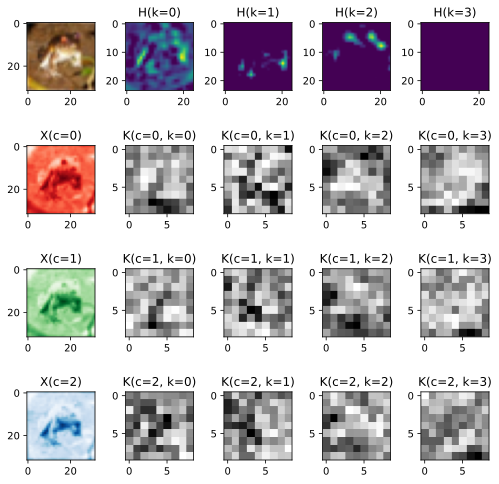

In [13]:
def visualize_conv_layer(*, image3d, conv):
    """Visualizing convolution kernels and output channels on a 3D image."""
    
    cmaps = ['Reds', 'Greens', 'Blues']
    X = image3d
    H = conv(X[None, :, :, :])[0, :, :, :]
    c_in  = X.shape[-1]
    c_out = H.shape[-1]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(7, 7))
    ax[0, 0].imshow(X[:, :, :])
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[:, :, c], cmap=cmaps[c])

    # Iterate over out channels
    for k in range(c_out):
        ax[0, k+1].imshow(H[:, :, k])
        ax[0, k+1].set_title(f'H(k={k})')

    # Iterate over kernel filters
    for k in range(c_out):
        for c in range(c_in):
            K = conv.get_weights()[0][:, :, c, k]
            ax[c+1, k+1].imshow(K, cmap='Greys') 
            ax[c+1, k+1].set_title(f'K(c={c}, k={k})')

    fig.tight_layout()


visualize_conv_layer(image3d=X_train[0], conv=model.layers[0]) # Frog?

Each kernel in entries `i, j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `H(k=j)` above. This has the structure of matrix multiplication which vanilla neural networks implement with numeric entries. But instead of products between numbers, here we have convolutions between matrices.

### Implementation

Testing that the formula discussed above is the same formula TensorFlow uses in `Conv2D`. Consistent with the above equation, TensorFlow expects input images to be of shape `(B, H, W, c)` for an batch input of size `B` of `H × W` images with `c` channels. This is also expected the shape of output of a convolutional layer.

Input shape:  (1, 32, 32, 3)
Output shape: (1, 24, 24, 4)
Kernel shape: (9, 9, 3, 4)
Bias shape:   (4,)
Mean absolute error = 5.1470124e-08


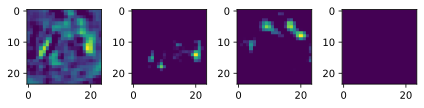

In [49]:
def conv2D(X, K, u, activation=None):
    """Implementing a 2D convolutional layer from scratch."""

    h, w = K.shape[:2]
    B, H_in, W_in, c_in = X.shape
    H_out, W_out = H_in-h+1, W_in-w+1
    c_out = K.shape[3]

    H = np.zeros(shape=(B, H_out, W_out, c_out))

    for b in range(H.shape[0]):
        for i in range(H.shape[1]):
            for j in range(H.shape[2]):
                for k in range(H.shape[3]):
                    if activation is None:
                        f = lambda x: x
                    else:
                        f = activation

                    # Perform 3D convolution (h, w, c_in) for each out channel
                    H[b, i, j, k] = f(u[k] + (K[:, :, :, k] * X[b, i:i+h, j:j+w, :]).sum())
    return H


X = X_train[0][None, :, :, :]   # (B, H_in, W_in, c_in)
conv = model.layers[0]          # [(5, 5, c_in, c_out), (c_out,)]

# Build and get kernel weights and biases
conv(X)
K = conv.weights[0].numpy()
u = conv.weights[1].numpy()
H = conv2D(X, K, u, activation=lambda x: max(0, x))

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", H.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with TF implementation
print("Mean absolute error =", np.abs(H - conv(X)).mean())

# Reconstructing...
fig, ax = plt.subplots(1, 4);
for j in range(4):
    ax[j].imshow(H[0, :, :, j])
fig.tight_layout()

### Convolution is a linear operation

In this section, we show that convolution is a **linear operation**. This can be shown directly from the definition, but here we show a particular construction of convolution as matrix multiplication. 

In [6]:
X = tf.convert_to_tensor(
    [[-1., 2.,-3.],
     [ 4.,-5., 6.],
     [-7., 8.,-9.],]
)[None, :, :, None]

K = tf.convert_to_tensor(
    [[-1.,  1.],
     [ 2., -2.]]
)[:, :, None, None]

conv_small = kr.layers.Conv2D(filters=1, kernel_size=(2, 2))
conv_small.build(input_shape=(256, 3, 3, 1))
conv_small.set_weights([K, tf.zeros(shape=(1,))])


X_ = np.array([-1., 2., -3., 4., -5., 6., -7., 8., -9.,])
K_ = np.array([
    [-1., 0., 0., 0.],
    [ 1.,-1., 0., 0.],
    [ 0., 1., 0., 0.],
    [ 2., 0.,-1., 0.],
    [-2., 2., 1.,-1.],
    [ 0.,-2., 0., 1.],
    [ 0., 0., 2., 0.],
    [ 0., 0.,-2., 2.],
    [ 0., 0., 0.,-2],
])

print((X_ @ K_).reshape(-1,))
print(tf.reshape(conv_small(X), (-1,)).numpy())

[ 21. -27. -39.  45.]
[ 21. -27. -39.  45.]


### Stride and padding

The above definition of convolution can be modified to include a parameter $s$ called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $s$ computes:

$$
\begin{aligned}
{\mathbf H}_{ij,\, k} 
&= \varphi\left(u_{k} + \sum_{c=0}^{c_\text{in}-1}\sum_{x = 0}^{k_h-1} \sum_{y=0}^{k_w-1} {\mathbf X}_{si + x,\, sj + y,\, c} \, {\mathbf K}_{xyc,{k}} \right)
\end{aligned}
$$


for $k = 0, \ldots, c_\text{out}-1.$ This includes the original definition which has a step size of 1. Note that strided convolutions can be thought of as a form of downsampling (discussed below) since it results in a significant reduction in image size. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. For example, AlexNet {cite}`imagenet-paper` used a kernel of size 11×11 with a stride of 4 in the first layer since objects in the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description) tend to occupy more pixels. 

<br>

```{figure} ../../img/imagenet.jpeg
---
width: 45em
name: imagenet
---
Sample images from the ImageNet dataset. {cite}`imagenet`

```

**Padding.** Observe that in the above definition of convolution, the kernel placed entirely within the input image. This has the disadvantage of being biased towards the center pixels, resulting in information loss on the edges of the input image. Also notice that applying convolutions will always result in decreasing spatial dimension which limits the depth of the network. A simple fix is to simply pad the edges with zero, which gives us more space to place the kernel over the edges of the image.


```{margin}
[[source]](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_05.png)
```
```{figure} ../../img/padding.png
---
width: 40em
---
```




<br>

This can implemented in TensorFlow using the `ZeroPadding2D` layer:

(256, 34, 34, 1)


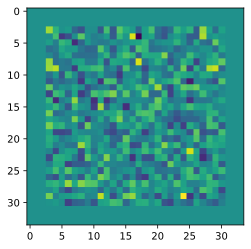

In [7]:
X = tf.random.normal(shape=(256, 28, 28, 1))            
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
plt.imshow(pad(X)[0, :, :, 0]);

### Output size

The spatial dimension of the output is directly influenced by padding `p` and stride `s`. Suppose the layer's input has width `W` and let the kernel have width `f`, then the output image has width `W_out = ⌊(W + 2p - f)/s⌋ + 1` assuming equal padding on both sides. 
Directly using discrete convolution is not always desirable as some pixels of the input are essentially dropped because a kernel cannot be placed within the image to cover them following the set stride:

```bash
input    1 2 3 4 5 6 7 8 9
kernel   0 0 1 0 0       
               0 0 1 0 0
         -----------------                     
output       3     6     
```

For odd kernel size `f` and unit stride `s = 1`, we can use `2p = f - 1` to get same sized outputs and with the kernel covering the entire input in a symmetric manner. For this reason, and also for the sake of symmetry, we [prefer odd-sized kernels](https://datascience.stackexchange.com/a/23186) for convolutions.

```bash
input    0 0 1 2 3 4 5 6 7 8 9 0 0
kernel   0 0 1 0 0
           0 0 1 0 0
                  ...
                       0 0 1 0 0
                         0 0 1 0 0
         -------------------------                        
output       1 2 3 4 5 6 7 8 9
```

For strides `s > 1`, the best practice is to choose a kernel size `f` and the smallest padding `p` such that `s` divides `W + 2p - f`. This way the entire input image is covered symmetrically by the kernel in constructing the convolved image.

```bash
input    0 1 2 3 4 5 6 7 8 9 0
kernel   0 0 1 0 0
               0 0 1 0 0
                     0 0 1 0 0
         ---------------------                         
output       2     5     8
```

**TF implementation.** The `padding` argument in `Conv2D` and other convolutional layers takes in either `"valid"` or `"same"`. The `"valid"` setting means that no padding is used an the kernel is placed only where it can be validly placed within the image. As discussed above this can result in discarding some pixels in the right as well as bottom part of the image. The `"same"` setting is a bit more tricky. Here the image is zero-padded as evenly as possible such that the output image has width `⌈W / s⌉`. Thus, if `⌊(W + 2p - f) / s⌋ + 1 == ⌈W / s⌉`, such as when `s = 1` and `2p = f-1`, then we can use `"same"` to implement a symmetric construction of the output as described above. Otherwise, we can apply `ZeroPadding2D` prior to convolution, resize the input images, or adjust the filter size as needed.

### Downsampling

For any unit of a hidden layer, its **receptive field** refers to all the units from all the previous layers that may affect the calculation of the unit during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. 

```{margin}
**Figure 14.2** in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 40em
---
Receptive field of a pixel in the third layer.
```

One way to increase receptive field is by **downsampling** which is defined as taking a sample, or aggregating samples, of pixels in the current layer so that we can pass a smaller input onto the next layer. This results in lower computational costs and a reduction in the capacity of the network which can be good. Downsampling is commonly done by means of a **pooling** operation.

A pooling layer operates like a convolutional layer in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max-pooling** takes 
the maximum value in the region that is covered by its kernel. One effect of max pooling is that it provides invariance to small translations of the input at the cost of some information loss. Note that max-pooling works well with the ReLU activation since all activation values subject to comparison are all nonnegative.

[[5 9]
 [4 8]]


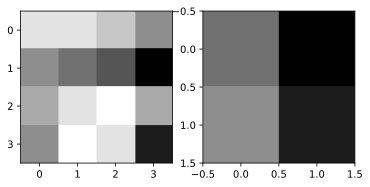

In [8]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)


plt.subplot(1, 2, 1)
plt.imshow(X.numpy()[0, :, :, 0], cmap='gray_r', vmin=0)

plt.subplot(1, 2, 2)
plt.imshow(pool(X).numpy().reshape(2, 2), cmap='gray_r', vmin=0)
print(pool(X).numpy().reshape(2, 2))

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 
In practice, there are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in worse performance. Observe below that there is more loss in finer detail when using overlapping pooling (right). 

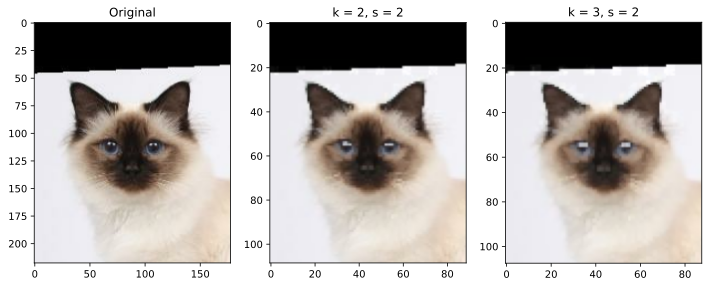

In [9]:
# Download cat image to `src/inefficient_networks/data/cat.jpg`
cat = config.DATASET_DIR / "cat.jpg"
image_raw = tf.io.read_file(str(cat))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=2, strides=2)(image)[0, :, :, :])
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=3, strides=2)(image)[0, :, :, :])
ax[2].set_title("k = 3, s = 2");

## Implementing a convnet

```{margin}
⚠ **Attribution:** This section is based on Chapter 14 of {cite}`mlbook2022`. The [PyTorch code](https://github.com/rasbt/machine-learning-book/) for this textbook is released under [MIT License](https://github.com/rasbt/machine-learning-book/blob/main/LICENSE.txt).
```

Using the Keras sequential API, let us implement the following convolutional network for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist` images. Note that use a width of 512 in the last dense layer to reduce network capacity, instead of using 1024 indicated in the figure below. We also add [batch normalization](https://arxiv.org/abs/1502.03167) {cite}`batchnorm` and check whether this improves model performance. 

```{figure} ../../img/convnet.png
---
---
Visualizing the structure of `model` below. [[source]](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)

```

Observe that the network follows the pattern where we stack `[Conv → ReLU → Pool]` blocks. This is typical in network design: using blocks composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels, then the resulting long vector is passed to a dense classification subnetwork.

In [10]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)      

In [11]:
def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
  1/782 [..............................] - ETA: 4:57 - loss: 3.2320 - accuracy: 0.2031

2022-05-05 13:21:36.992899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8200

2022-05-05 13:21:53.588992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 18s 23ms/step - loss: 0.5150 - accuracy: 0.8200 - val_loss: 0.3571 - val_accuracy: 0.8675
Epoch 2/20
782/782 [==============================] - 19s 24ms/step - loss: 0.3450 - accuracy: 0.8739 - val_loss: 0.3026 - val_accuracy: 0.8880
Epoch 3/20
782/782 [==============================] - 21s 27ms/step - loss: 0.2989 - accuracy: 0.8928 - val_loss: 0.2781 - val_accuracy: 0.8971
Epoch 4/20
782/782 [==============================] - 22s 28ms/step - loss: 0.2685 - accuracy: 0.9006 - val_loss: 0.2366 - val_accuracy: 0.9111
Epoch 5/20
782/782 [==============================] - 20s 26ms/step - loss: 0.2430 - accuracy: 0.9111 - val_loss: 0.2314 - val_accuracy: 0.9124
Epoch 6/20
782/782 [==============================] - 20s 26ms/step - loss: 0.2249 - accuracy: 0.9168 - val_loss: 0.2486 - val_accuracy: 0.9063
Epoch 7/20
782/782 [==============================] - 20s 25ms/step - loss: 0.2061 - accuracy: 0.9237 - val_loss: 0.2221 - val_accuracy: 0.9191
Epo

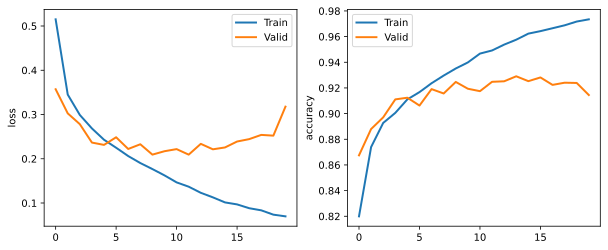

In [12]:
def plot_model_history(history, ax, metric='accuracy', label='', **kwargs):
    """Plotting result of Keras model training."""

    train_label = f'Train ({label})' if len(label) > 0 else 'Train'
    valid_label = f'Valid ({label})' if len(label) > 0 else 'Valid'
    ax[0].plot(history.history['loss'], label=train_label, color="C0", **kwargs)
    ax[0].plot(history.history['val_loss'], label=valid_label, color="C1", **kwargs)
    ax[0].set_ylabel('loss')
    ax[0].legend()

    ax[1].plot(history.history[metric], label=train_label, color="C0", **kwargs)
    ax[1].plot(history.history[f'val_{metric}'], label=valid_label, color="C1", **kwargs)
    ax[1].set_ylabel(metric)
    ax[1].legend()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

In [13]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 3s 9ms/step - loss: 0.3647 - accuracy: 0.9083
Test accuracy: 0.9083000421524048


Let us look at the model predictions:

In [14]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

2022-05-05 13:28:10.976578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Plotting the examples where model is least confident in its prediction:

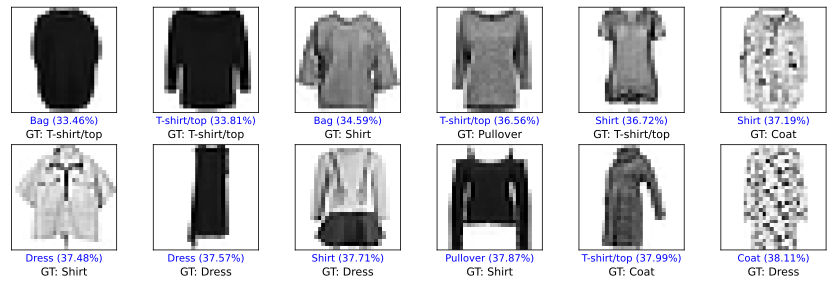

In [15]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_names[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

### Effect of batch normalization

Since we already have our experiment set up, might as well run some tests. Recall that we fitted batch normalization layers after the convolutional layers. Let us see how this affects model training.

In [16]:
model_no_bn = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])


# Build and compile with Adam and cross-entropy
model_no_bn.build(input_shape=(None, 28, 28, 1))
model_no_bn.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train on FashionMNIST data
hist_no_bn = model_no_bn.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
  1/782 [..............................] - ETA: 6:00 - loss: 2.3088 - accuracy: 0.1250

2022-05-05 13:28:13.680577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.8316

2022-05-05 13:28:32.858278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 21s 27ms/step - loss: 0.4694 - accuracy: 0.8316 - val_loss: 0.3081 - val_accuracy: 0.8869
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 0.2995 - accuracy: 0.8911 - val_loss: 0.2722 - val_accuracy: 0.9006
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 0.2561 - accuracy: 0.9074 - val_loss: 0.2620 - val_accuracy: 0.9031
Epoch 4/20
782/782 [==============================] - 19s 25ms/step - loss: 0.2260 - accuracy: 0.9165 - val_loss: 0.2225 - val_accuracy: 0.9179
Epoch 5/20
782/782 [==============================] - 20s 25ms/step - loss: 0.2023 - accuracy: 0.9251 - val_loss: 0.2102 - val_accuracy: 0.9193
Epoch 6/20
782/782 [==============================] - 20s 25ms/step - loss: 0.1817 - accuracy: 0.9320 - val_loss: 0.2353 - val_accuracy: 0.9152
Epoch 7/20
782/782 [==============================] - 21s 26ms/step - loss: 0.1648 - accuracy: 0.9396 - val_loss: 0.2056 - val_accuracy: 0.9238
Epo

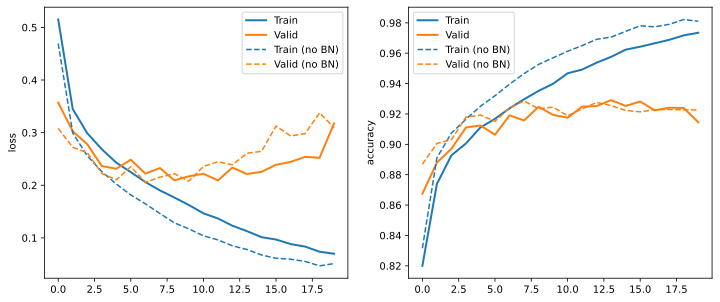

In [17]:
# Plot on same axis as prev model
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_model_history(history=hist, ax=ax, linewidth=2)
plot_model_history(history=hist_no_bn, ax=ax, label="no BN", linestyle="dashed")

Observe that the model with batch normalization exhibits less overfitting.

In [18]:
print(f"Test accuracy (BN):     {model.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy (w/o BN): {model_no_bn.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")

Test accuracy (BN):     90.83%
Test accuracy (w/o BN): 91.59%


## Data augmentation

```{margin}
⚠ **Attribution:** This section is based on Chapter 14 of {cite}`mlbook2022`. The [PyTorch code](https://github.com/rasbt/machine-learning-book/) for this textbook is released under [MIT License](https://github.com/rasbt/machine-learning-book/blob/main/LICENSE.txt).
```

In this section, we will create a convolutional network for classifying whether or not an image of a person is smiling or not. The dataset we will be using is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of celebrities’
faces. In addition, 40 binary facial attributes are available for each image, including whether a celebrity is smiling or not. 

To speed up training we will use only a small subset of 16,000 faces. However, this is a small dataset (even smaller than FashionMNIST). To increase the size of the dataset, and improve generalization, we will use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset resulting in a model that is robust to changes that should not affect semantics such as rotation and translation.

In [19]:
# Dowload data
utils.download_kaggle_dataset('jessicali9530/celeba-dataset')
image_dir_path = config.DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])

Dataset already exists in /Users/particle1331/code/inefficient-networks/src/inefficient_networks/data/celeba-dataset
Skipping download.


Plotting example images with their labels:

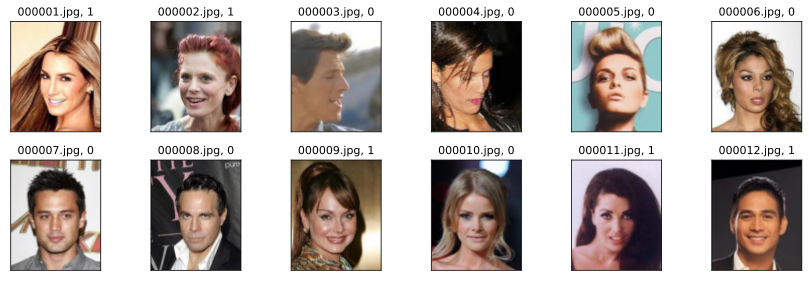

In [20]:
# Get id -> target dictionary
dataset_path = config.DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transformations

For the sake of demonstration, we apply various transformations on a single image. These are cropping to a bounding box, flipping horizontally, adjusting the contrast, adjusting the brightness, and  center-cropping and resizing the resulting image back to its original size, 218×178. All of these are available in the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) library.

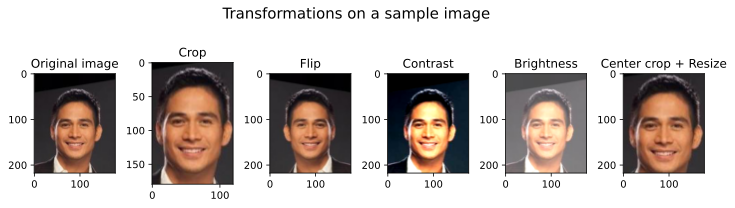

In [21]:
# Get sample image
image = plt.imread(face_file_list[11])

# Apply augmentations to sample image
cropped = tf.image.crop_to_bounding_box(image, 25, 30, 180, 120)
flipped = tf.image.flip_left_right(image)
contrast_adjusted = tf.image.adjust_contrast(image, 2.)
brightness_adjusted = tf.image.adjust_brightness(image, delta=0.3)
center_cropped = tf.image.central_crop(image, central_fraction=0.7)
resized_center_cropped = tf.image.resize(center_cropped, size=[218, 178]) / 255.

# Visualize
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

ax[0].set_title("Original image")
ax[1].set_title("Crop")
ax[2].set_title("Flip")
ax[3].set_title("Contrast")
ax[4].set_title("Brightness")
ax[5].set_title("Center crop + Resize")

ax[0].imshow(image)
ax[1].imshow(cropped)
ax[2].imshow(flipped)
ax[3].imshow(contrast_adjusted)
ax[4].imshow(brightness_adjusted)
ax[5].imshow(resized_center_cropped)

fig.suptitle("Transformations on a sample image", fontsize=15)
fig.tight_layout()

Observe that the transformations above are all deterministic. The idea behind data augmentation is that we can inject randomness into these transformations to get new data points (assuming this transformation does not change the label). For example, the parameters for contrast and brightness change can be drawn from some uniform distribution. For our training dataset we apply a sequence of transformation: first we perform random cropping so the model can focus more on the face, this is followed by a random horizontal flip, and a final resize to 64×64. For test data, we remove the stochasticity as we want to avoid unnecessary information loss.

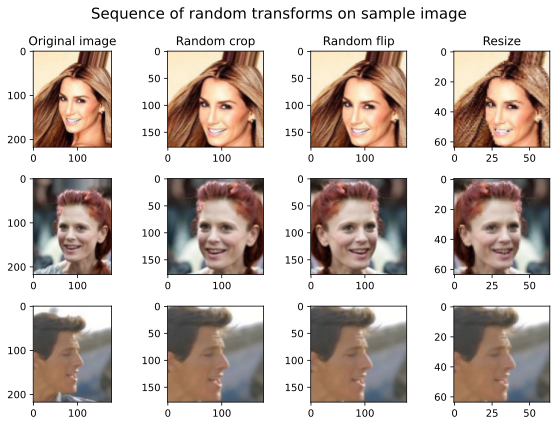

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Random crop")
ax[0, 2].set_title("Random flip")
ax[0, 3].set_title("Resize")

for i, file_name in enumerate(face_file_list[:3]):
    image = plt.imread(file_name)
    ax[i, 0].imshow(image)
    image = tf.image.random_crop(image, size=(178, 178, 3))
    ax[i, 1].imshow(image)
    image = tf.image.random_flip_left_right(image)
    ax[i, 2].imshow(image)
    image = tf.image.resize(image, size=[64, 64]) / 255.
    ax[i, 3].imshow(image)
    
fig.suptitle("Sequence of random transforms on sample image", fontsize=15)
fig.tight_layout()

The 64x64 images in the last column are those that will make up the training data. Next, we formalize this process by defining a tranformation pipeline and simulate how three sample images are presented to the model across multiple epochs. Note that we prefer using exactly one transformed version of an image per epoch so that the model is not biased, in contrast to the alternative of using multiple transformations of a single image in one epoch. We also want to avoid cropping too aggressively, otherwise we might crop the mouth out of the image which is highly predictive of a smile.

### Creating the augmented dataset

We now load the JPEG files into a TensorFlow dataset and apply the transformation to get a `MapDataset`. The whole process was introduced in a [previous notebook](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/01-tensorflow-nn.html#dataset-from-local-files). 

In [23]:
@tf.function
def transform(image, size=(64, 64), augment=True):
    """Full image transformation pipeline."""
    
    if augment:
        image = tf.image.random_crop(image, size=(178, 178, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0, 
            target_height=178, target_width=178
        ) # (218 - 178)/2 = 20, (178 - 178)/2 = 0

    image = tf.image.resize(image, size=size) / 255.
    return image
    

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image


def image_id(file_path):
    return file_path.split('/')[-1] 


def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds


# Create train, valid, and test data loaders outside of train loop.
# Here we assume that the dataset is shuffled in disk. Not sure though.
train_ds = create_image_dataset(face_file_list[:16000])
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (transform(x), y))

valid_ds = create_image_dataset(face_file_list[16000:17000])
valid_ds = valid_ds.map(lambda x, y: (transform(x, augment=False), y))

test_ds = create_image_dataset(face_file_list[17000:18000])
test_ds = test_ds.map(lambda x, y: (transform(x, augment=False), y))

Each dataset above is a `MapDataset` so that the mapping is applied lazily each time the dataset is iterated over. This is good since we want a different randomization for each epoch. Note that the ordering between `shuffle` and `map` seems to be significant as well as setting `reshuffle_each_iteration` to `True`. This is done so that `shuffle` [maintains state across iterations](https://github.com/tensorflow/tensorflow/issues/35682#issuecomment-578334425) and we get different augmentations for each epoch. Batch size for the data loaders will have to be set up later.

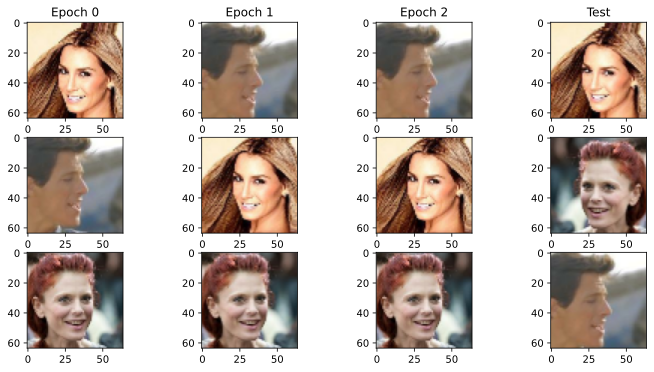

In [24]:
# In this demo, we likewise create loaders outside of train loops
train_demo = create_image_dataset(face_file_list[:3])
train_demo = train_demo.shuffle(1000)                           # order important! 
train_demo = train_demo.map(lambda x, y: (transform(x), y))     # shuffle -> map
train_demo = train_demo.batch(1)

fig, ax = plt.subplots(3, 4, figsize=(12, 6))

# Training
for epoch in range(3):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        ax[b, epoch].imshow(batch[0][0, :, :, :])

# Inference: use same images for comparison
test_demo = create_image_dataset(face_file_list[:3])
test_demo = test_demo.map(lambda x, y: (transform(x, augment=False), y))
test_demo = test_demo.batch(1)

ax[0, 3].set_title(f"Test")
for b, batch in enumerate(test_demo):
    ax[b, 3].imshow(batch[0][0, :, :, :])

Checking if the labels are balanced:

In [25]:
for ds in [train_ds, valid_ds, test_ds]:
    X, y = list(ds.batch(16000).as_numpy_iterator())[0]
    print(y.mean())

0.4813125
0.465
0.457


### Global average pooling

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification. The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using 3×3 same convolutions, 2×2 nonoverlapping max-pooling blocks. Batch normalization layers are also included for regularization.

In [26]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=256, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.GlobalAveragePooling2D(),
    
    kr.layers.Flatten(),
    kr.layers.Dense(units=2, activation='softmax')
])

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)      

At the final convolutional layer, we have 256 many 8×8 feature maps. Flattening this into a 256×8×8 = 16,384 long vector results in the loss of learned semantic structure. Not to mention the excess in capacity of the dense layer that takes this vector as input.

An alternative that we use here is a **global average-pooling** (GAP) layer which averages all pixels in the 8×8 feature map into a single pixel. Averaging over the spatial dimensions can make the model more robust to small spatial translations in the input. But more importantly, compressing the spatial dimension allows us to preserve the channel structure, while reducing the output to a vector of length 256. This vector can then be passed to a dense layer to perform classification. 

If the activations are nonnegative, each channel is forced to learn activation patterns, i.e. patterns in the kernel that result in activation, and averaging just summarizes how much the input matches this pattern. In fact, this has been used to construct maps which indicate the parts of the image that are discriminative!

<br>

```{figure} ../../img/cams.png
---
width: 50em
---
Global average pooling flattens the output of the convolutional base network. The outputs of the GAP layer are passed to a dense network with output dimension equal to the number of classes. It's learned weight is interpreted as importance and is used to construct maps which highlight class-specific discriminative regions. {cite}`cams`
```

### Model training and results

Training the model with Adam with a learning rate of $10^{-3}$ and a batch size of 32.

In [27]:
model.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(),
    optimizer=kr.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=30,
    validation_data=valid_ds.batch(256)
)

Epoch 1/30


2022-05-05 13:35:41.063867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.6443

2022-05-05 13:36:09.290500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 29s 57ms/step - loss: 0.6311 - accuracy: 0.6443 - val_loss: 0.6415 - val_accuracy: 0.6420
Epoch 2/30
500/500 [==============================] - 28s 56ms/step - loss: 0.4969 - accuracy: 0.7636 - val_loss: 0.5010 - val_accuracy: 0.7590
Epoch 3/30
500/500 [==============================] - 30s 60ms/step - loss: 0.3981 - accuracy: 0.8237 - val_loss: 1.5480 - val_accuracy: 0.5520
Epoch 4/30
500/500 [==============================] - 31s 62ms/step - loss: 0.3519 - accuracy: 0.8456 - val_loss: 0.3334 - val_accuracy: 0.8580
Epoch 5/30
500/500 [==============================] - 30s 59ms/step - loss: 0.3181 - accuracy: 0.8618 - val_loss: 0.5629 - val_accuracy: 0.7720
Epoch 6/30
500/500 [==============================] - 31s 61ms/step - loss: 0.3007 - accuracy: 0.8712 - val_loss: 0.3247 - val_accuracy: 0.8570
Epoch 7/30
500/500 [==============================] - 29s 58ms/step - loss: 0.2864 - accuracy: 0.8768 - val_loss: 0.2998 - val_accuracy: 0.8820
Epo

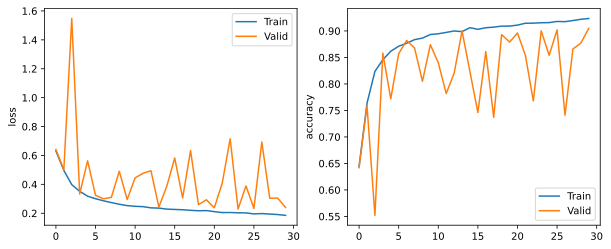

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax)

This looks good. The minimum validation loss roughly moves along with the train loss as the training progresses. One way to smooth out the validation curve is to get higher resolution input images. But here we already see that the network is able to learn with only 16,000 images by using data augmentation. In fact, if we turn off data augmentation, we get extreme divergence where the model overfits early on in the training. Again, this makes sense: adding random transformations on the train set makes it harder for the model to memorize it. At the same time, it learns to pick up representations that are invariant to these random perturbations in the inputs.



In [29]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%") # stochastic
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 92.19%
Valid accuracy: 90.50%
Test accuracy:  90.50%


In [30]:
pred_proba = model.predict(test_ds.batch(1000))[:, 1]
X_test, y_test = next(iter(test_ds.batch(1000)))
pred_table = pd.DataFrame({'pred': pred_proba, 'true': y_test})

2022-05-05 13:50:53.479991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


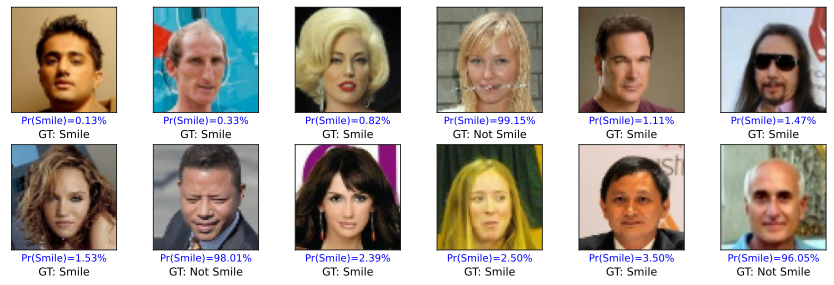

In [31]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

# Create distance of prediction from threshold of 0.5
pred_table['thresh_dist'] = np.abs(pred_table['pred'] - 0.5)
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['true']

confused = (pred_table
    .sort_values('thresh_dist', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X_test[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where the model is confident (gives a predict probability near either 0 or 1) but also wrong. This gives us an opportunity to check whether some labels are flipped. 

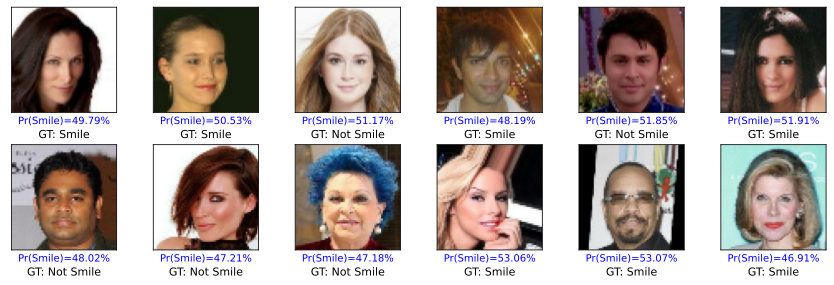

In [32]:
near_threshold = pred_table.sort_values('thresh_dist', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = near_threshold.index[i]
    image = X_test[image_index]
    row = near_threshold.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is not sure of whether the face is smiling or not (it gives a predict probability that is far from either 0 or 1). Some of these faces are ambiguous even for human labelers. 

## Class activation maps

Previously, we introduced the concept of **class activation maps** (CAMs) in the context of GAP layers. We will try to construct this for the current model. This constuct a map which highlights the class-specific discriminative regions of an input image. The construction is based on the paper {cite}`cams`. So a GAP-CNN network does not only tell us what objects are present in the image, it also tells us where these objects are in the image and with no further training!

Looking at the model summary, note that the GAP layer output has 258 units. To construct the class activation maps, for each input $\mathbf x$ we take the activations of the final ReLU layer which has shape (8, 8, 256) as **activation maps** $f_i(\mathbf x)$ of shape (8, 8) for $i = 1, \ldots, 256$ with nonnegative pixel values. Then, we take the weights $w_{ij}$ of the dense layer which maps the output of the GAP layer to binary classes with label $j$ (smile or not smile), and compute the sum

$$\textsf{CAM}(\mathbf x, j) = \sum_{i=1}^{256}  f_i(\mathbf x) w_{ij}.$$

The resulting image is (8, 8) which we can resize for better resolution. Then we overlay this on the input image $\mathbf x$ resized to the same height and width. Thus, what we've done here is expand the linear combination of zero-dimensional average activation values to a linear combination of 2-dimensional activation maps. CAMs are implemented in the following code block for test examples.

Note that class scores are obtained by a linear combination of the average pixel values in each activation map. Since spatial ordering is preserved by convolutional layers, then the activations should indicate which pixels in the input that is in its receptive field triggered the activation, i.e. whose local representation matched the pattern in the kernel. Moreover, since the activation maps have positive pixel values, we can use the weights in the linear combination as a measure of importance for each activation for a given class.

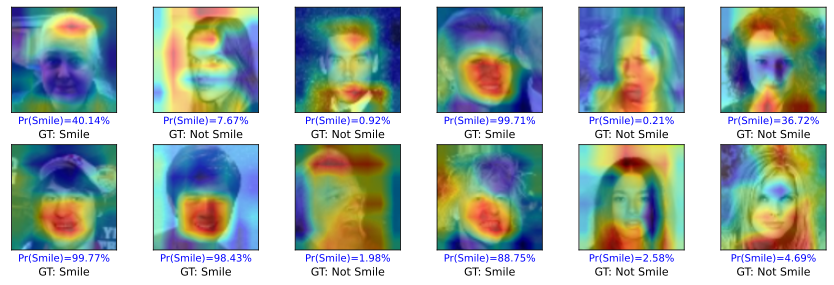

In [33]:
from functools import reduce

def plot_cam(batch, height=96, width=96):
    """Plot class activation maps (CAM) for each image in batch.
    The CAM will be taken with respect to the predicted label."""

    X, Y = batch
    class_label = {0: 'Not Smile', 1: 'Smile'}
    class_weight = model.layers[-1].get_weights()[0]
    resize = kr.layers.Resizing(height, width)
    fig, ax = plt.subplots(2, 6, figsize=(12, 4))

    for b in range(12):
        x = X[b, :, :, :][None, :, :, :]
        y = Y[b]
        t = tf.argmax(model(x), axis=1)[0]

        # Apply layers up to final conv. activation. (1, 8, 8, 256) -> (64, 256)
        act_map = tf.reshape(reduce(lambda x, f: f(x), model.layers[:-4], x), (-1, 256))
        weights = class_weight[:, t][:, None]
        cam = act_map @ weights
        cam = resize(tf.reshape(cam, (8, 8, 1)))
        
        ax[divmod(b, 6)].imshow(resize(x[0]))
        ax[divmod(b, 6)].imshow(cam, alpha=0.7, cmap='jet')
        ax[divmod(b, 6)].set_xlabel(f"Pr(Smile)={model(x)[0, 1]*100:.2f}%", color='blue')
        ax[divmod(b, 6)].set_title(f"GT: {class_label[y.numpy()]}", y=-0.3, fontsize=11)
        ax[divmod(b, 6)].set_xticks([])
        ax[divmod(b, 6)].set_yticks([])

    fig.tight_layout()


plot_cam(batch=next(iter(test_ds.batch(12)))) # Detect smile

**Figure.** CAMs of test images for the predicted class. Red regions indicate high activation values, hence local discriminative features. Notice that the model is able to find discriminative features around the mouth area for detecting the presence of smile. For not smile, activation regions are not as well-defined.

## Transfer learning

```{margin}
⚠ **Attribution.** This section is based on the Keras Guide [*Transfer learning & fine-tuning*](https://keras.io/guides/transfer_learning) adapted to our current experiment.
```

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments.


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network, that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting `trainable = False`.
 3. Add new layers on top of the base model.
 4. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we obviously cannot use it along with data augmentation which transforms input data at each training iteration.

In [34]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top
inputs = kr.Input(shape=(64, 64, 3))
x = kr.layers.Resizing(96, 96)(inputs)
x = base_model(x, training=False)          # Inference mode! ⚠⚠⚠
x = kr.layers.AvgPool2D(pool_size=3)(x)    # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               327936

Setting `model.trainable` to `False` recursively moves all trainable weights to non-trainable. In particular, this has the side-effect of disabling updates to batch normalization statistics. This makes sense since the trainable parameters that they interact with are frozen. Note that this side-effect is redundant with `base_model(x, training=False)`.

**Remark.** This last setting will be important when we unfreeze the pretrained model weights for fine-tuning. According to the [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute), it is usually still better to keep the moving statistics frozen when fine-tuning even while the trainable parameters are updating. Forcing pretrained model calls in inference mode does exactly this, as it is not overridden by training calls to `model` (see appendix).

In [35]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=20,
    validation_data=valid_ds.batch(256)
)

Epoch 1/20


2022-05-05 13:51:00.250353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.5921 - binary_accuracy: 0.6814

2022-05-05 13:51:31.597275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 35s 65ms/step - loss: 0.5921 - binary_accuracy: 0.6814 - val_loss: 0.5439 - val_binary_accuracy: 0.7270
Epoch 2/20
500/500 [==============================] - 34s 67ms/step - loss: 0.5294 - binary_accuracy: 0.7239 - val_loss: 0.5267 - val_binary_accuracy: 0.7340
Epoch 3/20
500/500 [==============================] - 36s 71ms/step - loss: 0.5167 - binary_accuracy: 0.7320 - val_loss: 0.5241 - val_binary_accuracy: 0.7380
Epoch 4/20
500/500 [==============================] - 35s 70ms/step - loss: 0.5039 - binary_accuracy: 0.7398 - val_loss: 0.5212 - val_binary_accuracy: 0.7360
Epoch 5/20
500/500 [==============================] - 36s 71ms/step - loss: 0.4965 - binary_accuracy: 0.7469 - val_loss: 0.5084 - val_binary_accuracy: 0.7390
Epoch 6/20
500/500 [==============================] - 35s 70ms/step - loss: 0.4905 - binary_accuracy: 0.7484 - val_loss: 0.5131 - val_binary_accuracy: 0.7450
Epoch 7/20
500/500 [==============================] - 34s 67ms/

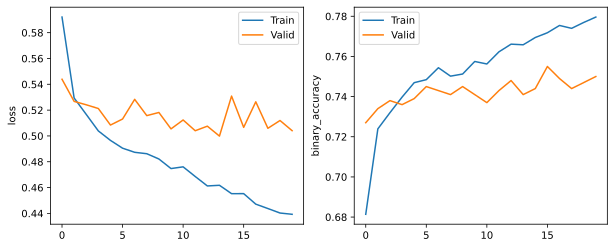

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

In [37]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 78.36%
Valid accuracy: 75.00%
Test accuracy:  73.60%


### Fine-tuning

A last, optional step, is **fine-tuning**, which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [38]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Train end-to-end. Be careful to stop before you overfit!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist = model.fit(
    train_ds.batch(32), 
    epochs=epochs, 
    validation_data=valid_ds.batch(256),
    callbacks=[callback]
)

Epoch 1/10


2022-05-05 14:03:10.043975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.4122 - binary_accuracy: 0.7966

2022-05-05 14:04:49.969727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 108s 205ms/step - loss: 0.4122 - binary_accuracy: 0.7966 - val_loss: 0.4101 - val_binary_accuracy: 0.8060
Epoch 2/10
500/500 [==============================] - 99s 195ms/step - loss: 0.3315 - binary_accuracy: 0.8439 - val_loss: 0.3742 - val_binary_accuracy: 0.8230
Epoch 3/10
500/500 [==============================] - 94s 187ms/step - loss: 0.2936 - binary_accuracy: 0.8658 - val_loss: 0.3264 - val_binary_accuracy: 0.8440
Epoch 4/10
500/500 [==============================] - 102s 203ms/step - loss: 0.2732 - binary_accuracy: 0.8733 - val_loss: 0.3223 - val_binary_accuracy: 0.8760
Epoch 5/10
500/500 [==============================] - 101s 200ms/step - loss: 0.2520 - binary_accuracy: 0.8826 - val_loss: 0.3121 - val_binary_accuracy: 0.8770
Epoch 6/10
500/500 [==============================] - 101s 201ms/step - loss: 0.2398 - binary_accuracy: 0.8881 - val_loss: 0.2803 - val_binary_accuracy: 0.8880
Epoch 7/10
500/500 [==============================] -

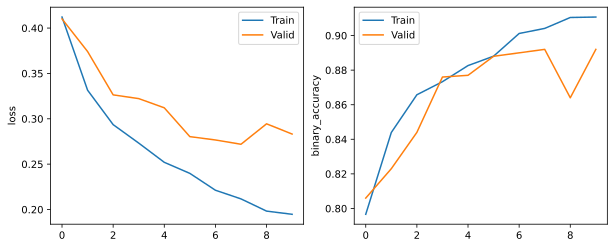

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

As expected, the model is starting to overfit due to overcapacity (the train-valid loss gap is widening). And we were not able to obtain a better test scores with fine-tuning (see below). It would be nice if we had better results with transfer learning (before fine-tuning), but this is likely due to hardware limitations. For more powerful systems, we expect better performing networks with transfer learning.

In [40]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(1000), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds.batch(1000),  verbose=0)[1] * 100:.2f}%")

Train accuracy: 92.91%
Valid accuracy: 89.20%
Test accuracy:  87.80%


## Appendix

### MobileNetV2 architecture

In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Batch normalization layers in transfer learning

Testing two facts about batch norm layers: (1) that batch norm layers are forced to run in inference mode when weights are frozen, and (2) setting `base_model` calls to inference mode keeps its batch normalization layers in inference mode even if outer `model` calls are in training mode.

In [42]:
def training_mean_change(model):
    """Max change in mean of BN layer after one call in training mode."""

    # Get sample input
    x = tf.random.normal((1, 3))

    # Change in mean after one call in train mode
    u0 = model.weights[2].numpy()
    model(x, training=True)
    u1 = model.weights[2].numpy()
    
    return (u1 - u0).max()


# Control: training mode, trainable weights
x = kr.Input(shape=(3,))
h = kr.layers.BatchNormalization()(x)
bn_model = kr.Model(inputs=x, outputs=h)

training_mean_change(bn_model)

0.010963601

Running the same experiment with frozen weights in training mode. Getting `0.0` proves (1) above:

In [43]:
# Freeze weights
bn_model.trainable = False
training_mean_change(bn_model)

0.0

Next, we mimic the network structure for a transfer learning fine-tuning task. Recall that `base_model` is set in inference mode inside `model`. Getting `0.0` with trainable weights and running the outer model in training mode proves (2) above: 

In [44]:
# "Pretrained model"
x = kr.Input(shape=(3,))
h = kr.layers.BatchNormalization()(x)
base_model = kr.Model(inputs=x, outputs=h)

# Pretrained model in inference mode
x = kr.Input(shape=(3,))
h = base_model(x, training=False)
h = kr.layers.Dense(2)(h)
model = kr.Model(inputs=x, outputs=h)

# Model training... (unfreeze weights)
model.trainable = True
training_mean_change(model)

0.0